# Лабораторна 2 - Feature Engineering: покращення даних для навчання

Виконав: Тивонюк Володимир ФБ-41мн

#### Завантаження необхідних бібліотек - буду використовувачи PyTorch

[dataset here](https://www.kaggle.com/datasets/orvile/sperm-morphology-image-data-set-smids?resource=download) Sperm Morphology Image Data Set (SMIDS)

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset, random_split

import numpy as np
import matplotlib.pyplot as plt
import time
import os
import copy
from PIL import Image, UnidentifiedImageError
import sklearn.metrics
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

Using device: cuda:0


In [3]:
def load_bsp_as_pil(path):
    try:
        img = Image.open(path)
        img = img.convert('RGB')
        return img
    except UnidentifiedImageError:
        print(f"Error: PIL cannot identify image file format for: {path}")
        raise
    except FileNotFoundError:
        print(f"Error: File not found at path: {path}")
        raise
    except Exception as e:
        print(f"An unexpected error occurred loading {path}: {e}")
        raise

### data_transforms в комбінації DatasetWrapper виконують аугментацію - feature engineering датасету

Визначаю параметри трансформації (включаючи аугментацію для feature engineering),
завантажую датасет

In [16]:

data_dir = 'SMIDS'
img_size = 224
batch_size = 32

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_transforms_no_aug = {
    'train': transforms.Compose([ # Лише базові трансформації
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': data_transforms['val'], # Використовуємо ті ж для val/test
    'test': data_transforms['test'],
}

full_dataset_orig = datasets.ImageFolder(
    data_dir,
    loader=load_bsp_as_pil,
    transform=None # Без трансформацій тут
)
dataset_sizes = {
 'train': len(train_dataset_transformed), # Розмір однаковий
 'val': len(val_dataset_transformed),
 'test': len(test_dataset_transformed)
}
print("Dataset sizes:", dataset_sizes)

Dataset sizes: {'train': 2100, 'val': 450, 'test': 450}


Розділяю на train/val/test

In [8]:
class_names = full_dataset_orig.classes
num_classes = len(class_names)
print(f"Found {len(full_dataset_orig)} images in {num_classes} classes: {class_names}")

total_size = len(full_dataset_orig)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size
print(f"Splitting: Train={train_size}, Val={val_size}, Test={test_size}")
train_dataset, val_dataset, test_dataset = random_split(
    full_dataset_orig, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(42)
)

class DatasetWrapper(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform
    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y
    def __len__(self):
        return len(self.subset)

train_dataset_transformed = DatasetWrapper(train_dataset, transform=data_transforms['train'])
val_dataset_transformed = DatasetWrapper(val_dataset, transform=data_transforms['val'])
test_dataset_transformed = DatasetWrapper(test_dataset, transform=data_transforms['test'])

dataloaders = {
    'train': DataLoader(train_dataset_transformed, batch_size=batch_size, shuffle=True, num_workers=0),
    'val': DataLoader(val_dataset_transformed, batch_size=batch_size, shuffle=False, num_workers=0),
    'test': DataLoader(test_dataset_transformed, batch_size=batch_size, shuffle=False, num_workers=0)
}

train_dataset_no_aug = DatasetWrapper(train_dataset, transform=data_transforms_no_aug['train'])
val_dataset_no_aug = DatasetWrapper(val_dataset, transform=data_transforms_no_aug['val'])
test_dataset_no_aug = DatasetWrapper(test_dataset, transform=data_transforms_no_aug['test'])

dataloaders_no_aug = {
    'train': DataLoader(train_dataset_no_aug, batch_size=batch_size, shuffle=True, num_workers=0),
    'val': DataLoader(val_dataset_no_aug, batch_size=batch_size, shuffle=False, num_workers=0),
    'test': DataLoader(test_dataset_no_aug, batch_size=batch_size, shuffle=False, num_workers=0)
}

Found 3000 images in 3 classes: ['Abnormal_Sperm', 'Non-Sperm', 'Normal_Sperm']
Splitting: Train=2100, Val=450, Test=450


Як виглядає датасет:

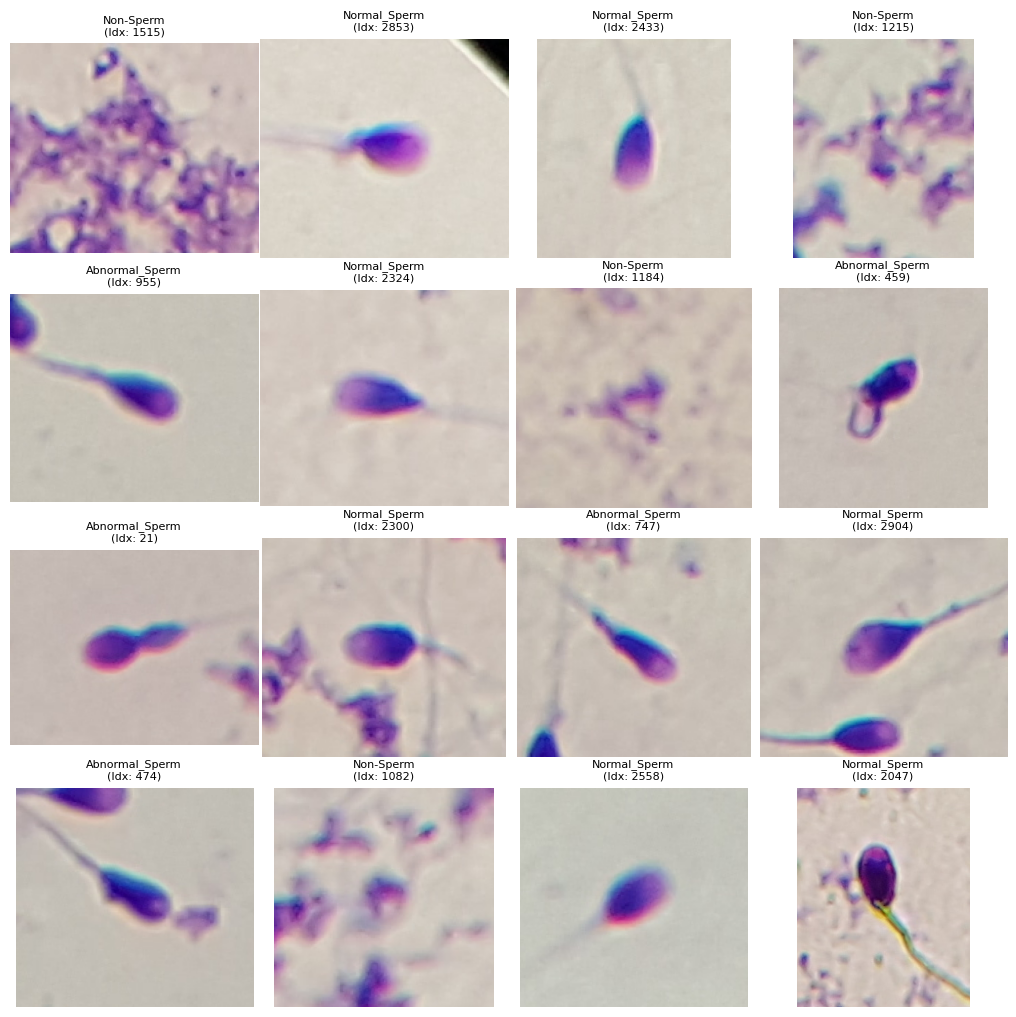

In [11]:
fig, axs = plt.subplots(4, 4, figsize=(10, 10)) # Slightly smaller figsize
random_indices = np.random.randint(0, len(full_dataset_orig), 16)

for i, ax in enumerate(axs.flat): 
    if i >= 16: 
         ax.axis('off')
         continue
    img, label_idx = full_dataset_orig[random_indices[i]]
    label_name = class_names[label_idx]

    ax.imshow(img)
    ax.set_title(f"{label_name}\n(Idx: {random_indices[i]})", fontsize=8)
    ax.axis('off')

plt.tight_layout(pad=0.1)
plt.show()

Функція сетапу моделей

In [12]:
def setup_model(num_classes, pretrained=True, feature_extract=True):
    if pretrained:
        print("Loading PRE-TRAINED ResNet18.")
        weights = models.ResNet18_Weights.IMAGENET1K_V1
        model = models.resnet18(weights=weights)
    else:
        print("Loading ResNet18 with RANDOM weights.")
        model = models.resnet18(weights=None)

    if feature_extract and pretrained:
        print("Freezing parameters for feature extraction.")
        for param in model.parameters():
            param.requires_grad = False

    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)
    print(f"Replaced final layer: Linear({num_ftrs}, {num_classes}).")

    if feature_extract and pretrained:
         for param in model.fc.parameters():
              param.requires_grad = True

    return model, 224

model_feat_eng, _ = setup_model(num_classes, pretrained=True, feature_extract=True)
model_feat_eng = model_feat_eng.to(device)

model_baseline, _ = setup_model(num_classes, pretrained=False)
model_baseline = model_baseline.to(device)

Loading PRE-TRAINED ResNet18.
Freezing parameters for feature extraction.
Replaced final layer: Linear(512, 3).
Loading ResNet18 with RANDOM weights.
Replaced final layer: Linear(512, 3).


Аналогічні першій лабораторній функції для навчання, візуалізації та евалюації моделі

In [13]:
def train_model(model, criterion, optimizer, scheduler, dataloaders, dataset_sizes, device, num_epochs=25):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    print(f"\nStarting training for {num_epochs} epochs...")
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train': model.train()
            else: model.eval()

            running_loss = 0.0
            running_corrects = 0
            loader = dataloaders[phase]
            num_samples = dataset_sizes[phase]

            for inputs, labels in loader:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train' and scheduler: scheduler.step()

            epoch_loss = running_loss / num_samples
            epoch_acc = running_corrects.double() / num_samples
            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc.item())
            print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                print(f'  >> New best validation accuracy: {best_acc:.4f}')
        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')
    model.load_state_dict(best_model_wts)
    return model, history

def plot_history(history, title):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss'); plt.plot(history['val_loss'], label='Val Loss')
    plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title(f'{title} - Loss'); plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train Acc'); plt.plot(history['val_acc'], label='Val Acc')
    plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title(f'{title} - Accuracy'); plt.legend()
    plt.tight_layout(); plt.show()

In [14]:
def evaluate_model(model, loader, device, class_names):
    model.eval()
    all_preds, all_labels = [], []
    print(f"\nEvaluating model on {len(loader.dataset)} samples...")
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = sklearn.metrics.accuracy_score(all_labels, all_preds)
    report = sklearn.metrics.classification_report(all_labels, all_preds, target_names=class_names, digits=4)
    cm = sklearn.metrics.confusion_matrix(all_labels, all_preds)

    print(f"\nEvaluation Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(report)

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label'); plt.ylabel('True Label'); plt.title('Confusion Matrix'); plt.show()

    return accuracy, report, cm

Оптимізація та тренування моделі з аугментованими даними


Starting training for 15 epochs...
Epoch 0/14
----------
Train Loss: 1.1322 Acc: 0.4414
Val Loss: 1.2292 Acc: 0.4111
  >> New best validation accuracy: 0.4111

Epoch 1/14
----------
Train Loss: 0.8853 Acc: 0.5619
Val Loss: 0.8392 Acc: 0.5422
  >> New best validation accuracy: 0.5422

Epoch 2/14
----------
Train Loss: 0.8409 Acc: 0.6119
Val Loss: 0.8083 Acc: 0.6267
  >> New best validation accuracy: 0.6267

Epoch 3/14
----------
Train Loss: 0.7780 Acc: 0.6519
Val Loss: 0.7918 Acc: 0.6889
  >> New best validation accuracy: 0.6889

Epoch 4/14
----------
Train Loss: 0.7202 Acc: 0.6886
Val Loss: 0.8853 Acc: 0.6111

Epoch 5/14
----------
Train Loss: 0.6930 Acc: 0.7200
Val Loss: 0.6003 Acc: 0.7489
  >> New best validation accuracy: 0.7489

Epoch 6/14
----------
Train Loss: 0.6703 Acc: 0.7324
Val Loss: 1.1641 Acc: 0.5289

Epoch 7/14
----------
Train Loss: 0.6463 Acc: 0.7524
Val Loss: 0.6051 Acc: 0.7600
  >> New best validation accuracy: 0.7600

Epoch 8/14
----------
Train Loss: 0.6218 Acc: 0.

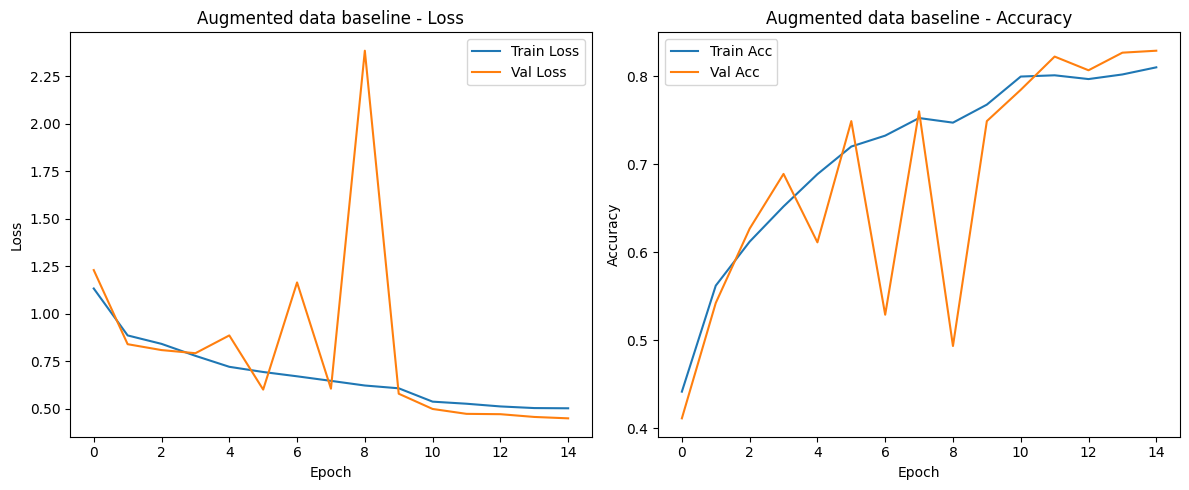

In [17]:
model_baseline_trained = model_baseline
criterion_scratch = nn.CrossEntropyLoss()
optimizer_scratch = optim.Adam(model_baseline_trained.parameters(), lr=0.001)
exp_lr_scheduler_scratch = lr_scheduler.StepLR(optimizer_scratch, step_size=10, gamma=0.1)

num_epochs_scratch = 15
model_baseline_trained, history_scratch = train_model(
    model_baseline_trained, criterion_scratch, optimizer_scratch, exp_lr_scheduler_scratch,
    dataloaders, dataset_sizes, device, num_epochs=num_epochs_scratch
)

plot_history(history_scratch, "Augmented data baseline")

Евалюація даної моделі:


Evaluating model on 450 samples...

Evaluation Accuracy: 0.8356

Classification Report:
                precision    recall  f1-score   support

Abnormal_Sperm     0.7857    0.8521    0.8176       142
     Non-Sperm     0.9535    0.7593    0.8454       162
  Normal_Sperm     0.7904    0.9041    0.8435       146

      accuracy                         0.8356       450
     macro avg     0.8432    0.8385    0.8355       450
  weighted avg     0.8476    0.8356    0.8360       450



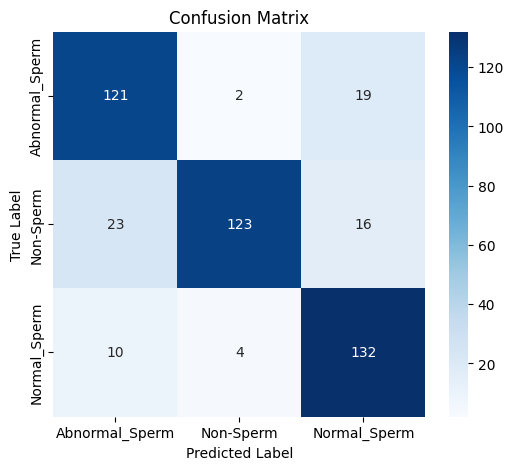

In [18]:
results = {}
if 'model_baseline_trained' in locals():
    accuracy_feat_eng, report_feat_eng, cm_feat_eng = evaluate_model(
        model_baseline_trained, dataloaders['test'], device, class_names
    )
    results['baseline'] = {'accuracy': accuracy_feat_eng, 'report': report_feat_eng, 'cm': cm_feat_eng}

Оптимізація та тренування базової моделі без аугментації - для порівняння


Starting training for 15 epochs...
Epoch 0/14
----------
Train Loss: 0.6021 Acc: 0.7719
Val Loss: 0.5301 Acc: 0.7867
  >> New best validation accuracy: 0.7867

Epoch 1/14
----------
Train Loss: 0.5323 Acc: 0.8148
Val Loss: 0.5837 Acc: 0.7578

Epoch 2/14
----------
Train Loss: 0.5070 Acc: 0.8167
Val Loss: 0.9093 Acc: 0.5956

Epoch 3/14
----------
Train Loss: 0.4536 Acc: 0.8333
Val Loss: 0.4850 Acc: 0.8089
  >> New best validation accuracy: 0.8089

Epoch 4/14
----------
Train Loss: 0.4332 Acc: 0.8362
Val Loss: 0.7240 Acc: 0.6778

Epoch 5/14
----------
Train Loss: 0.4473 Acc: 0.8271
Val Loss: 0.4887 Acc: 0.7956

Epoch 6/14
----------
Train Loss: 0.4074 Acc: 0.8457
Val Loss: 0.8464 Acc: 0.7089

Epoch 7/14
----------
Train Loss: 0.3975 Acc: 0.8471
Val Loss: 0.5260 Acc: 0.7933

Epoch 8/14
----------
Train Loss: 0.3651 Acc: 0.8681
Val Loss: 0.7966 Acc: 0.7022

Epoch 9/14
----------
Train Loss: 0.3667 Acc: 0.8619
Val Loss: 0.5471 Acc: 0.7956

Epoch 10/14
----------
Train Loss: 0.3514 Acc: 0.8

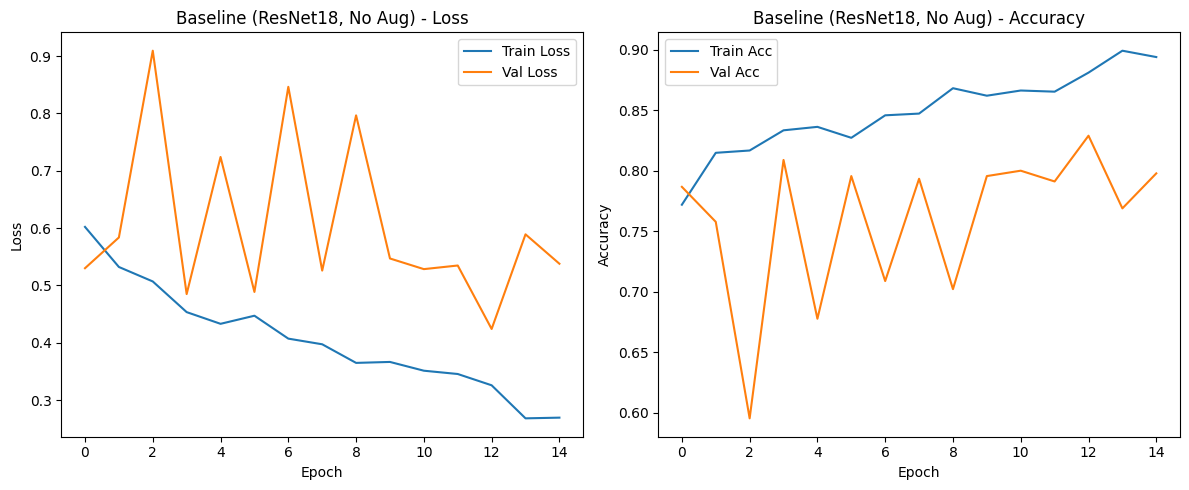

In [20]:
model_baseline_noaug_resnet = model_baseline # Перейменовуємо для ясності
model_baseline_noaug_resnet = model_baseline_noaug_resnet.to(device)

criterion_baseline_noaug = nn.CrossEntropyLoss()
optimizer_baseline_noaug = optim.Adam(model_baseline_noaug_resnet.parameters(), lr=0.001)
exp_lr_scheduler_baseline_noaug = None


num_epochs_baseline_noaug = 15 

model_baseline_noaug_trained, history_baseline_noaug = train_model(
    model_baseline_noaug_resnet,
    criterion_baseline_noaug,
    optimizer_baseline_noaug,
    exp_lr_scheduler_baseline_noaug,
    dataloaders_no_aug, 
    dataset_sizes,
    device,
    num_epochs=num_epochs_baseline_noaug
)

plot_history(history_baseline_noaug, "Baseline (ResNet18, No Aug)")

Навчання досить нестабільше з базовою моделлю - але вона загалом краще навіть без аугментації для мого датасету


Evaluating model on 450 samples...

Evaluation Accuracy: 0.8444

Classification Report:
                precision    recall  f1-score   support

Abnormal_Sperm     0.7815    0.8310    0.8055       142
     Non-Sperm     0.9448    0.8457    0.8925       162
  Normal_Sperm     0.8117    0.8562    0.8333       146

      accuracy                         0.8444       450
     macro avg     0.8460    0.8443    0.8438       450
  weighted avg     0.8501    0.8444    0.8458       450



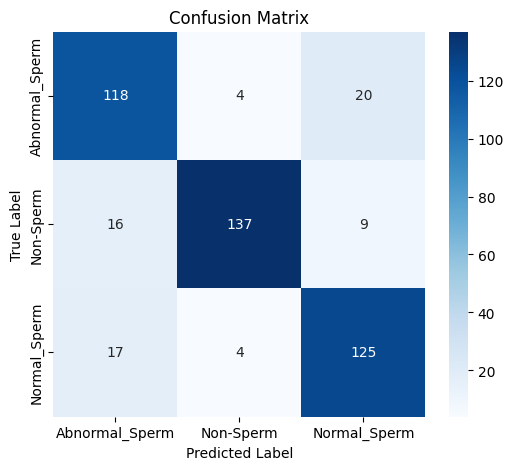

In [21]:
if 'model_baseline_noaug_trained' in locals():
    accuracy_baseline_noaug, report_baseline_noaug, cm_baseline_noaug = evaluate_model(
        model_baseline_noaug_trained,
        dataloaders_no_aug['test'],
        device,
        class_names
    )
    results['baseline_resnet_no_aug'] = {'accuracy': accuracy_baseline_noaug, 'report': report_baseline_noaug, 'cm': cm_baseline_noaug}

In [23]:
baseline_aug = results.get('baseline')
baseline_noaug = results.get('baseline_resnet_no_aug')

print("\nMethod 1: Baseline:")
print(f"  Test Accuracy: {baseline_aug['accuracy']:.4f}")

print("\nMethod 2: Baseline no aug:")
print(f"  Test Accuracy: {baseline_noaug['accuracy']:.4f}")


Method 1: Baseline:
  Test Accuracy: 0.8356

Method 2: Baseline no aug:
  Test Accuracy: 0.8444


## Висновки:
В якості Feature Engineering було застосовано аугментацію даних (випадкові трансформації зображень для тренування).
Різниці це не дало загалом що аугментували картинки, специфіка датасету. Порівняння з чи без feature engineering датасету в результаті навчання моделі краще видно на цікавішому датасеті та можливо на трансформері.
Також базовий Feature Engineering в формі ResNet Feature Extraction був використаний в моделях попередньої лаби - використання переднавченої моделі ResNet18 як екстрактора ознак.